In [3]:
!pip install pymorphy2
!wget -O pymorphy2-dicts-ru.tar.gz https://files.pythonhosted.org/packages/b2/b4/732ff6eeac8c9ea22e7e1c7a321b21b6f3ba19d5e0a8925f35da9c8ebbb2/pymorphy2-dicts-ru-2.4.404381.4453942.tar.gz

     |████████████████████████████████| 55 kB 149 kB/s eta 0:00:011
     |████████████████████████████████| 8.0 MB 4.7 MB/s eta 0:00:01
--2020-09-27 10:43:59--  https://files.pythonhosted.org/packages/b2/b4/732ff6eeac8c9ea22e7e1c7a321b21b6f3ba19d5e0a8925f35da9c8ebbb2/pymorphy2-dicts-ru-2.4.404381.4453942.tar.gz
Resolving files.pythonhosted.org (files.pythonhosted.org)... 151.101.201.63, 2a04:4e42:2f::319
Connecting to files.pythonhosted.org (files.pythonhosted.org)|151.101.201.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7934073 (7.6M) [binary/octet-stream]
Saving to: ‘pymorphy2-dicts-ru.tar.gz’

pymorphy2-dicts-ru. 100%[===================>]   7.57M  3.10MB/s    in 2.4s    

2020-09-27 10:44:03 (3.10 MB/s) - ‘pymorphy2-dicts-ru.tar.gz’ saved [7934073/7934073]



In [25]:
import pickle

import tarfile
from tqdm import tqdm_notebook as tqdm

from multiprocessing import Pool


import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stop = stopwords.words('russian')

from string import punctuation
punkt= [p for p in punctuation] + ["`", "``" ,"''", "'"]


import gensim
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import fasttext
import pymorphy2

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split


# !pip install MulticoreTSNE
from sklearn.decomposition import TruncatedSVD
from MulticoreTSNE import MulticoreTSNE as TSNE


In [5]:
rudict = tarfile.open('./pymorphy2-dicts-ru.tar.gz')
rudict.extractall()
rudict.close()

In [6]:
lemmatizer = pymorphy2.MorphAnalyzer(path='./pymorphy2-dicts-ru-2.4.404381.4453942/pymorphy2_dicts_ru/data',lang='ru')

In [7]:

data = pd.read_csv('../input/corpus-of-russian-news-articles-from-lenta/lenta-ru-news.csv')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
data.date = pd.to_datetime(data.date)

In [9]:
topics_to_use = data.topic.value_counts()[data.topic.value_counts() > 5000].index

In [10]:
data = data[data.topic.isin(topics_to_use)]

In [11]:
data.topic.value_counts(normalize=True)

Россия               0.217844
Мир                  0.185497
Экономика            0.107979
Спорт                0.087457
Культура             0.073043
Бывший СССР          0.072507
Наука и техника      0.072145
Интернет и СМИ       0.060641
Из жизни             0.037481
Дом                  0.029509
Силовые структуры    0.026606
Ценности             0.010544
Бизнес               0.010046
Путешествия          0.008700
Name: topic, dtype: float64

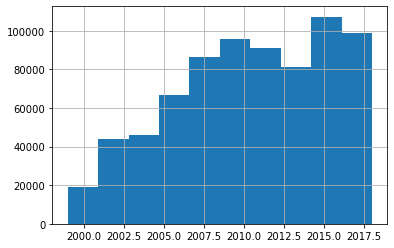

In [12]:
data.date.dt.year.hist()

In [13]:
data.head(10)

,url,title,text,topic,tags,date
5,https://lenta.ru/news/1999/08/31/stancia_mir/,"Космонавты сомневаются в надежности ""Мира""",Как стало известно агентству Ассошиэйтед Пресс...,Россия,Все,1999-08-31
6,https://lenta.ru/news/1999/08/31/vzriv/,Взрыв в центре Москвы: пострадало 30 человек,В зале игровых автоматов в третьем ярусе подзе...,Россия,Все,1999-08-31
7,https://lenta.ru/news/1999/08/31/credit_japs/,Япония кредитует Россию на полтора миллиарда д...,Япония приняла решение разморозить кредиты Рос...,Россия,Все,1999-08-31
8,https://lenta.ru/news/1999/08/31/diana/,Британцы отмечают двухлетие смерти Дианы,Британцы отмечают сегодня скорбную дату - втор...,Мир,Все,1999-08-31
9,https://lenta.ru/news/1999/08/31/mvf/,Отмытые через Bank of NY деньги не имели отнош...,В понедельник директор департамента внешних св...,Россия,Все,1999-08-31
10,https://lenta.ru/russia/1999/08/31/tamozhnya/,C 1 сентября вводится новая форма таможенной д...,С 1 сентября на всей территории России вводитс...,Россия,Все,1999-08-31
11,https://lenta.ru/news/1999/08/31/fsb/,Создан департамент ФСБ по борьбе с терроризмом,Указом президента России Бориса Ельцина внесен...,Россия,Все,1999-08-31
12,https://lenta.ru/news/1999/08/31/cholera/,Южно-Сахалинск объявлен очагом холеры,Сегодня областной центр Сахалина и Курил получ...,Россия,Все,1999-08-31
13,https://lenta.ru/news/1999/08/31/polit_blok/,Леворадикалы создают предвыборный блок,Бывший шеф Службы безопасности президента Але...,Россия,Все,1999-08-31
14,https://lenta.ru/news/1999/08/31/turkey_quake/,Еще одно землетрясение в Турции: один человек ...,"подземный толчок силой 5,2 балла На северо-зап...",Мир,Все,1999-08-31


In [14]:
data.size

4419078

In [15]:
data[data.topic.isna()]

,url,title,text,topic,tags,date


In [16]:
news_title = data['title']
news_text = data['text']
news_topic = data['topic']

In [17]:
def tokenize(sent):
    try:
        sent = word_tokenize(sent)
        return [word for word in sent if word not in stop and word not in punkt]
    
    except:
        return []
    
def lemmatize(sent):
    try:
        return " ".join([lemmatizer.normal_forms(word)[0] for word in sent])
    except:
        return " "

    
def preprocess_sent(sent):
    return lemmatize(tokenize(sent))

In [18]:
s = news_text[:100].tolist()

In [19]:
preprocess_sent(s[0])

'как стать известно агентство ассошиэйтед пресс экипаж последний экспедиция станция мир считать способный выйти из-под контроля.командир виктор афанасьев сказать мы чувствовать грустить оставить станция летать беспилотный режим gazeta ru подробно писать финансирование программа мир закрытый конструктор спешить топить тихий океан надеяться изыскание внебюджетный средств.онить надеяться правительство оплатить финальный экспедиция мир февраль март 2000 год новый экспедиция должный постепенно перевести станция низкий орбита 140- тонный мир основное сгореть атмосфера незначительный часть упасть тихий океан но никакой гарантия пережить столько отказ оборудование конструкция повести адекватно команда афанасьев перечислить потенциально опасный элемент мир пресс- конференция состояться понедельник звёздный городок мочь упасть давление кабина сказать это стать серьёзный препятствие работа следующий экспедиция слишком большой роль человеческий фактор элементарный ошибка привести потеря топливо по

In [20]:
with Pool(8) as p:
    titles_preprocessed = list(tqdm(
                                    p.imap(preprocess_sent, news_title.tolist()),
                                    total=news_title.size
                                    )
                             )

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [26]:
# with open('titles_preprocessed.pkl', 'wb') as write_titles:
#     pickle.dump(titles_preprocessed, write_titles)

In [21]:
y = news_topic.tolist()

In [22]:
title_train, title_test, y_train, y_test = train_test_split(titles_preprocessed, y, test_size=0.25, stratify=y, random_state=33)

In [23]:
with open('train_data_titles.txt', 'w+', encoding='utf-8') as tr:
    for idx in range(len(title_train)):
        tr.write('__label__' + y_train[idx]+' '+title_train[idx]+'\n')
        
with open('test_data_titles.txt', 'w+', encoding='utf-8') as te:
    for idx in range(len(title_test)):
        te.write('__label__' + y_test[idx]+' '+title_test[idx]+'\n')        

In [24]:
%%time
ft_model = fasttext.train_supervised(input='train_data_titles.txt')

CPU times: user 27.5 s, sys: 66.8 ms, total: 27.6 s
Wall time: 10.1 s


In [27]:
ft_model.predict(preprocess_sent('Акула съела банкира: акции банка упали на 25%'), k=3)

(('__label__Экономика', '__label__Мир', '__label__Россия'),
 array([0.97794479, 0.01008974, 0.00406314]))

In [28]:
ft_model.predict(preprocess_sent('Кремль обеспокоен: висит груша, нельзя скушать'), k=3)

(('__label__Россия', '__label__Экономика', '__label__Культура'),
 array([0.91482884, 0.04722932, 0.02813784]))

In [29]:
ft_model.predict(preprocess_sent('В Австралии перестали интересоваться футболом'), k=3)

(('__label__Мир', '__label__Дом', '__label__Экономика'),
 array([0.3679814 , 0.27845356, 0.18571404]))

In [30]:
ft_model.test('test_data_titles.txt', k=1)

(184129, 0.8926676406215208, 0.8926676406215208)

In [31]:
%%time
ft_model_p1 = fasttext.train_supervised(input='train_data_titles.txt', epoch=10, wordNgrams=2, loss='hs', lr=1.0)

CPU times: user 47.9 s, sys: 852 ms, total: 48.7 s
Wall time: 17.7 s


In [32]:
ft_model_p1.test('test_data_titles.txt',k=1)

(184129, 0.8796007147163131, 0.8796007147163131)

In [41]:
%%time
ft_model_p_o = fasttext.train_supervised(input='train_data_titles.txt', autotuneValidationFile='test_data_titles.txt')

CPU times: user 19min 15s, sys: 12.4 s, total: 19min 27s
Wall time: 6min 51s


In [42]:
ft_model_p_o.test('test_data_titles.txt')

(184129, 0.8935746134503527, 0.8935746134503527)

In [48]:
print(f'Best learning rate: {ft_model_p_o.lr} \nBest epochs: {ft_model_p_o.epoch} \nBest_word_Ngrams: {ft_model_p_o.wordNgrams}')

Best learning rate: 0.1872916200812178 
Best epochs: 35 
Best_word_Ngrams: 2


In [43]:
# ft_model_p_o.save_model('lenta_titles_ft_model.bin')

In [35]:
with open('titles_unsupervised.txt', 'w+', encoding='utf-8') as titles:
    for idx in range(len(titles_preprocessed)):
        titles.write(titles_preprocessed[idx]+'\n')

In [36]:
%%time
ft_vectors = fasttext.train_unsupervised('titles_unsupervised.txt', minn=3,maxn=5, dim=50)

CPU times: user 4min 55s, sys: 620 ms, total: 4min 56s
Wall time: 1min 40s


In [37]:
ft_vectors.get_word_vector('инвестиция')

array([-0.5492909 , -0.14699346, -0.12042818,  1.1571444 , -0.06187404,
        0.6658829 , -0.03170357, -0.20216225,  0.157697  ,  0.5417557 ,
        0.15256022, -0.23685145,  0.06988641,  0.21336302, -0.03895294,
       -0.13558193,  0.81273055,  0.6568987 , -0.30831784, -0.04364332,
        0.4666397 , -0.8862593 , -0.96765625, -0.02632582, -0.04978538,
       -0.35545334, -0.08357198, -0.15939897,  1.1631788 ,  0.9273125 ,
       -0.6651015 , -0.28445566,  0.81425804,  0.11212516, -0.5320517 ,
       -0.99324864, -0.66688937,  0.17435434, -0.3457242 , -1.2469343 ,
        0.49151954,  0.63043225,  0.10374542, -0.49296713, -0.08314773,
        0.30136773, -0.41309687, -0.68195224,  0.24260685, -0.34621212],
      dtype=float32)

In [38]:
ft_vectors.get_subwords('инвестиция')

(['инвестиция',
  '<ин',
  '<инв',
  '<инве',
  'инв',
  'инве',
  'инвес',
  'нве',
  'нвес',
  'нвест',
  'вес',
  'вест',
  'вести',
  'ест',
  'ести',
  'естиц',
  'сти',
  'стиц',
  'стици',
  'тиц',
  'тици',
  'тиция',
  'ици',
  'иция',
  'иция>',
  'ция',
  'ция>',
  'ия>'],
 array([   1728, 1616787, 1398169, 1351440,  267375, 2030542,  215520,
         207806, 1790256,  322309, 1413349,  889524,  951108,  779222,
         512902,   78955,  987895,  442998,  114662,  881484, 1473356,
        1347456,  953941, 1908669, 1416191, 1795309,  263663, 1510276]))

In [39]:
ft_vectors.get_nearest_neighbors('инвестиция')

[(0.902620255947113, 'инвест'),
 (0.9025967717170715, 'инвестпроект'),
 (0.8960946202278137, 'инвестиционный'),
 (0.8788821697235107, 'инвестфонд'),
 (0.8775863647460938, 'вложение'),
 (0.8671990633010864, 'инвестпрограмма'),
 (0.8614265322685242, 'инвестфорум'),
 (0.8549183011054993, 'инвесткомпание'),
 (0.8335928320884705, 'инвестор'),
 (0.8315266370773315, 'инвестирование')]

In [40]:
ft_vectors.get_nearest_neighbors('инвестеция')

[(0.9463585615158081, 'инвест'),
 (0.9286243319511414, 'инвестфонд'),
 (0.9245961308479309, 'инвестпроект'),
 (0.9242355823516846, 'инвестиция'),
 (0.8837417364120483, 'инвестбанк'),
 (0.8796676993370056, 'инвестфорум'),
 (0.874826192855835, 'инвестбанкир'),
 (0.8689512014389038, 'инвесткомпание'),
 (0.8678358793258667, 'вэб'),
 (0.861279308795929, 'инвестпрограмма')]

In [81]:
print(len(ft_vectors.words))
top3k = ft_vectors.words[:3000]
top3k[:10]

33919


['</s>',
 'в',
 '«',
 '»',
 'россия',
 'российский',
 'сша',
 'москва',
 'новый',
 'год']

In [82]:
top3k_vectors = [ft_vectors.get_word_vector(word) for word in top3k]

In [83]:
%%time
tsne_emb = TSNE(n_components=2, n_iter=2000, n_jobs=-1).fit_transform(np.array(top3k_vectors))

CPU times: user 1min 44s, sys: 56.6 s, total: 2min 41s
Wall time: 41 s


In [84]:
tsne_emb.shape

(3000, 2)

In [87]:
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook

output_notebook()


p = figure(tools="pan,wheel_zoom,reset,save", title="TSNE representation of FastText vectors (top 3k words)")

source = ColumnDataSource(data=dict(x1=tsne_emb[:,0], x2=tsne_emb[:,1], names=top3k))

p.scatter(x="x1", y="x2", source=source, size=5)

words = LabelSet(x="x1", y="x2", text="names", source=source,
                y_offset=6, text_font_size="6pt",text_color="#555555", text_align="center")

p.add_layout(words)

show(p)


Loading BokehJS ...

In [107]:
titles_for_w2v = [sent.split(" ") for sent in titles_preprocessed]

In [110]:
%%time
from gensim.models import Word2Vec
w2v = Word2Vec(sentences=titles_for_w2v, min_count=3, size=50, window=6, seed=33, workers=4)


CPU times: user 1min 57s, sys: 748 ms, total: 1min 58s
Wall time: 1min 3s


In [131]:
w2v.save('lenta_titles_w2v_model.bin.gz')

In [132]:
w2v = Word2Vec.load('lenta_titles_w2v_model.bin.gz')
type(w2v)

gensim.models.word2vec.Word2Vec

In [133]:
w2v_vectors = w2v.wv

In [134]:
w2v_vectors['инвестиция']

array([-1.0695839 ,  1.960322  ,  0.12414386,  0.28195405, -0.90945894,
        0.45063195,  0.78824526,  2.016368  , -1.6883105 , -1.6991211 ,
       -0.0193555 , -0.3633283 , -0.28799754,  0.10037071, -0.15621026,
       -0.6541482 , -0.6689993 ,  1.0476491 , -1.4398888 ,  0.66496503,
       -0.19094566, -1.0978314 ,  1.3242036 ,  0.11257345, -1.3463323 ,
       -1.0668012 ,  0.61953807, -0.24309972, -0.25490168, -1.2472842 ,
       -1.8520228 ,  2.3334377 , -2.4614253 , -1.2275758 , -2.3372812 ,
       -0.34167156,  1.582743  ,  0.97968495, -1.6152902 ,  0.6935503 ,
       -0.6041029 , -0.641709  ,  0.23978573,  1.6684241 ,  3.567335  ,
        0.12992601, -0.3753898 ,  0.29659927, -1.1348177 ,  0.4032888 ],
      dtype=float32)

In [135]:
w2v_vectors['инвестеция']

KeyError: "word 'инвестеция' not in vocabulary"

In [136]:
w2v.most_similar('инвестиция')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('вложение', 0.8718881607055664),
 ('объём', 0.8071343898773193),
 ('доля', 0.780134916305542),
 ('промышленность', 0.7798504829406738),
 ('резерв', 0.7792683839797974),
 ('отрасль', 0.7785140872001648),
 ('кредитование', 0.7757391333580017),
 ('доходность', 0.7630425095558167),
 ('капитал', 0.759934663772583),
 ('кредит', 0.7580652236938477)]

In [137]:
w2v.most_similar('коррупция')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('злоупотребление', 0.8323959708213806),
 ('взяточничество', 0.83113694190979),
 ('растрата', 0.8184129595756531),
 ('рейдерство', 0.785250186920166),
 ('антисемитизм', 0.7546790838241577),
 ('госизмена', 0.7544577717781067),
 ('махинация', 0.7531402707099915),
 ('шантаж', 0.7350651621818542),
 ('мошенничество', 0.735011100769043),
 ('терроризм', 0.7263022661209106)]

In [138]:
w2v.most_similar(positive=['чиновник'], negative=['взяточничество'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('бюджетник', 0.5312211513519287),
 ('госслужащий', 0.5179216861724854),
 ('товар', 0.5149902701377869),
 ('пенсионер', 0.5018435120582581),
 ('гастарбайтер', 0.5017959475517273),
 ('школьник', 0.480804979801178),
 ('продукт', 0.4760134220123291),
 ('турист', 0.4737367033958435),
 ('депутат', 0.4708818793296814),
 ('избиратель', 0.4645194411277771)]